# AGH Modelling of Physical Systems Lab 3 (2025 March 18th)
Sylwester Arabas (sylwester.arabas@agh.edu.pl)

**1. advection PDE**

Let's introduce a few symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   
* ${\color{brown}u}$: carrier velocity field (e.g., wind)   

Transport of $\color{green}\psi$ due to advection by $\color{brown}u$ can be modelled with the advection equation:
$$ \partial_{\color{red} t} {\color{green}\psi} + \partial_{\color{blue}x} \left({\color{brown}u} {\color{green}\psi}\right) = 0 $$

For the special case of $\partial_{\color{blue}x} {\color{brown}u}=0$, an analytical solution describing translation of the signal is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=\psi_0({\color{blue}x} - {\color{brown}u}{\color{red}t})$$
where $\psi_0({\color{blue}x})={\color{green}\psi}({\color{blue}x}, 0)$. 

Let's depict the problem using NumPy and matplotlib:

In [60]:
! pip install numpy
! pip install matplotlib
! pip install open-atmos-jupyter-utils

In [61]:
import numpy as np
from matplotlib import pyplot

In [62]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

In [63]:
psi_0 = Psi_0()
nx = 64
x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
u = 1.5
t_max = 50

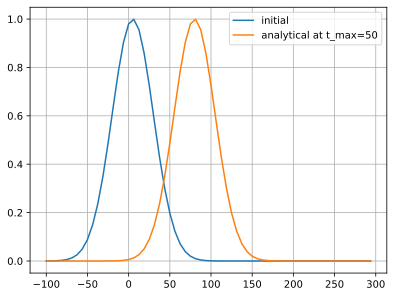

In [64]:
pyplot.plot(x, psi_0(x), label='initial')
pyplot.plot(x, psi_0(x - u * t_max), label=f'analytical at {t_max=}')
pyplot.legend()
pyplot.grid()

**2. overview of applications**

* **computational fluid dynamics**: Navier-Stokes momentum equation ($\psi$: fluid momentum)
* **fluid thermodynamics**: energy conservation ($\psi$: thermal energy)
* **atmospheric modelling incl. weather prediction**: mass conservation ($\psi$: humidity, rain, pollutants, ...)
* **derivative pricing in financial mathematics**: Black-Scholes equation ($\psi$: discounted value of a derivative instrument)
* ...

**3. simple numerical solution using the "upwind" scheme coded in Python**

For cases where the velocity varies in space (and for many other more complex cases), numerical integration is the only way of solving the advection PDE. Among numerous numerical schemes for solving it, let's look at the basic [**upwind**](https://en.wikipedia.org/wiki/Upwind_scheme) solver: 

Let's consider the following discretisation of the problem:   
* ${\color{red}n} = \frac{\color{red}t}{\Delta t} \in 0, 1, \ldots$   
* ${\color{blue}i} = \frac{\color{blue}x}{\Delta x} \in 0, 1, \ldots$   
* ${\color{brown}C} = {\color{brown}u}\frac{\Delta t}{\Delta x}$ (so called Courant number)   
* ${\color{green}\psi}_{\color{blue}i}^{\color{red}n}$: scalar field at "grid cell" $\color{blue}i$ in space at time "level" ${\color{red}n}$   

The explicit (forward-in-time) upwind scheme is defined as:
$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[F\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i},  {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}, {\color{brown}C}\right)-F\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1},{\color{green}\psi}^{\color{red}n}_{\color{blue}i}, {\color{brown}C}\right)\right]
$$
$$F(\psi_L, \psi_R, C)=\frac{C+|C|}{2}\psi_L + \frac{C-|C|}{2}\psi_R$$

**4. upwind algorithm coded in Python/NumPy: functions and a useful structure**

In [65]:
def F(L,R,C):
    return .5*(C+abs(C))*L + .5*(C-abs(C))*R

**5. upwind algorithm coded in Python/NumPy: data/objects**

In [66]:
class One:
    def __radd__(self, o):
        return slice(o.start+1, o.stop+1)
    
    def __rsub__(self, o):
        return slice(o.start-1, o.stop-1)

**6. upwind algorithm coded in Python/NumPy: time-stepping loop**

In [67]:
one = One()
psi = psi_0(x)
i = slice(1, nx-2)
# nt = 50
nt = 16
dt = t_max/nt
C = u*dt/dx
for _ in range(nt):
    psi[i] = psi[i] - (F(psi[i], psi[i+one], C) - F(psi[i-one], psi[i], C))

**7. comparing analytic and numerical solutions**

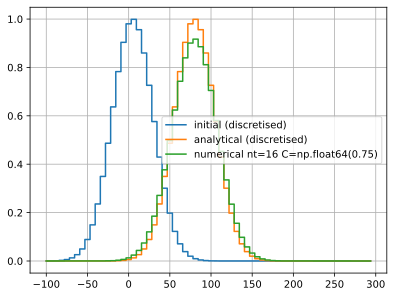

In [68]:
pyplot.step(x, psi_0(x), label='initial (discretised)', where='mid')
pyplot.step(x, psi_0(x-u*t_max), label='analytical (discretised)', where='mid')
pyplot.step(x, psi, label=f'numerical {nt=} {C=}', where='mid')
pyplot.legend()
pyplot.grid()

# Comparison of RMSE between numerical and analytic solution across different dx/dt

In the following comparison, we're investigating how the RMSE changes over different values of dt/dx. By generating these graphs we're able to detect the point of diminishing returns for decreasing the value of dx/dt.

In [69]:
def RMSE(analytic, discrete):
    res = 0
    for i in range(0, len(discrete)):
        res += (analytic[i] - discrete[i]) ** 2
    
    res = np.sqrt(res/len(discrete))

    return res

In [70]:
from open_atmos_jupyter_utils import show_plot


psi_0 = Psi_0()
one = One()
u = 1.5
t_max = 50


Cs = [0.5, 0.75, 0.3, 0.9]
# C = 0.75

c_rmse_dts = []
c_dts = []
c_rmse_dxs = []
c_dxs = []

for C in Cs:

    rmse_dt = []
    dts = []
    rmse_dx = []
    dxs = []

    # Different dt
    nx = 64
    x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
    nt_arr = range(32, 256)
    i = slice(1, nx-2)


    for nt in nt_arr:
        psi = psi_0(x)
        dt = t_max/nt
        # C = u*dt/dx
        for _ in range(nt):
            psi[i] = psi[i] - (F(psi[i], psi[i+one], C) - F(psi[i-one], psi[i], C))
        rmse_dt.append(RMSE(psi_0(x-u*t_max), psi))
        dts.append(dt)

    # Different dx
    nx_arr = range(32, 256)
    nt = 16
    dt = t_max/nt

    for nx in nx_arr:
        x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
        i = slice(1, nx-2)
        psi = psi_0(x)
        # C = u*dt/dx
        for _ in range(nt):
            psi[i] = psi[i] - (F(psi[i], psi[i+one], C) - F(psi[i-one], psi[i], C))
        rmse_dx.append(RMSE(psi_0(x-u*t_max), psi))
        dxs.append(dx)

    c_rmse_dts.append(rmse_dt)
    c_rmse_dxs.append(rmse_dx)
    c_dts.append(dts)
    c_dxs.append(dxs)


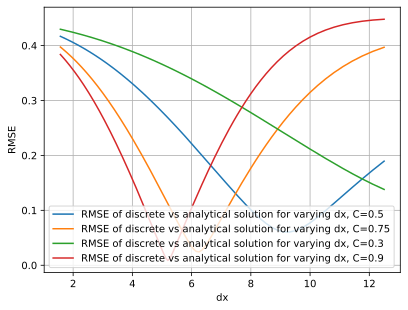

In [71]:

# Plot RMSE graphs
for i in range(len(Cs)):
    pyplot.plot(c_dxs[i], c_rmse_dxs[i], label=f"RMSE of discrete vs analytical solution for varying dx, C={Cs[i]}")

pyplot.xlabel("dx")
pyplot.ylabel("RMSE")
pyplot.legend()
pyplot.grid()
show_plot()

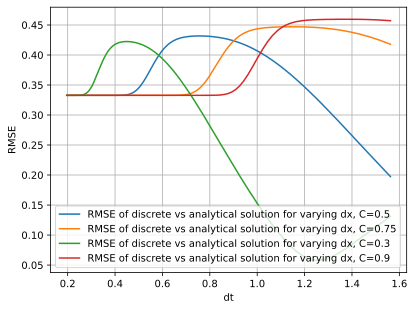

In [72]:
# Plot RMSE graphs
for i in range(len(Cs)):
    pyplot.plot(c_dts[i], c_rmse_dts[i], label=f"RMSE of discrete vs analytical solution for varying dx, C={Cs[i]}")

pyplot.xlabel("dt")
pyplot.ylabel("RMSE")
pyplot.legend()
pyplot.grid()
show_plot()

## Conclusions
By looking at the RMSE-dx graph we can see that the higher our **C** value is, the smaller step dx should have for best accuracy. At **C=0.9** the error amounted to nothing at around *dx=5*. 

The graph for RMSE-dt is far more inconclusive, for **C=0.3** we can see that there is a similiar error minimum at around *dt=1.25*. For other values of **C** the optimal *dt* value is far higher.


In conclusion, for any given advection model, depending on the value of **C** the optimal values of dt/dx are different to mitigate the error.